In [5]:
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
cudnn.benchmark = True
plt.ion()   # interactive m
from datetime import datetime
now = datetime.now
T0 = now()

from IPython import display
import sys
import seaborn as sns

In [6]:
from torchvision.models import resnet50
from torch.utils.data import Dataset, DataLoader
#from torchvision.models import resnet50, ResNet50_Weights


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
torch.cuda.get_device_name(0)

RuntimeError: No CUDA GPUs are available

In [8]:
class HAA_dataset(Dataset):
    "Video frame Dataset"
    def __init__(self,data_dir,usage='train'):
        self.data_dir = data_dir
        self.categories = os.listdir(self.data_dir)
        self.categories.sort()
        self.n_cat = len(self.categories)
        self.usage = usage
        
        ## To make test and val, deterministic
        ## Works on images
        ## doest seem to affect transforms
        if self.usage=='train':
            seed = np.random.randint(2147483647) 
            random.seed(seed) 
            torch.manual_seed(seed)
            np.random.seed(seed)
        else:
            seed = 42
            random.seed(seed) 
            torch.manual_seed(seed)
            np.random.seed(seed)
        
        frames = []
        for category in self.categories:
            folder_frames = [frame for frame in os.listdir(os.path.join(data_dir,category)) if not frame.startswith('.')]
            folder_frames.sort()
            frames.append(folder_frames)
        self.frames = frames
        
        self.Ts = transforms.Compose([transforms.ColorJitter(brightness=.3, contrast=.3, saturation=.3, hue=.3),
        transforms.GaussianBlur(kernel_size=(5,9), sigma=(0.1, 2.0))])
        
    def __len__(self):
        return 10_000 # 
        
    def __getitem__(self, idx):
        
        self.rand_cat = np.random.randint(low=0,high=self.n_cat)
        self.rand_frame = np.random.randint(low=0,high=len(self.frames[self.rand_cat]))
        fn = os.path.join(self.data_dir,self.categories[self.rand_cat],self.frames[self.rand_cat][self.rand_frame])
        im = Image.open(fn)
        im = Ts(im)
        im = np.array(im)
        im = im/255
        im = im.swapaxes(2,1).swapaxes(0,1)
        
        #sample = {'image': torch.from_numpy(image).float(), 'label': torch.from_numpy(label).float()}  # make a dict with the image and the correct label
        sample = {'image': torch.from_numpy(im).float(), 'label': torch.from_numpy(np.array([self.rand_cat])).float()}  # make a dict with the image and the correct label
        return sample
    
    
    def get_im(self,rand_cat,frame_idx=None):
        self.rand_cat = rand_cat
        
        if type(frame_idx)==type(None): # For training, randomly choose image
            self.rand_frame = np.random.randint(low=0,high=len(self.frames[self.rand_cat]))
        else: # For val and test, deterministic 
            self.rand_frame = np.mod(frame_idx,len(self.frames[self.rand_cat])) # a spell that loops over array infinitely
            
        fn = os.path.join(self.data_dir,self.categories[self.rand_cat],self.frames[self.rand_cat][self.rand_frame])
        im = Image.open(fn)
        
        if self.usage=='train': # if training, add transforms for data augmentation
            im = self.Ts(im)
            
        im = np.array(im)
        im = im/255
        im = im.swapaxes(2,1).swapaxes(0,1)
        
        return im
    
    def get_batch(self,batch_size):
        self.this_batch_cats = np.random.randint(low=0,high=self.n_cat,size=batch_size)
        self.this_batch_cats = np.array(self.this_batch_cats)
        self.this_batch_im = [self.get_im(i) for i in self.this_batch_cats]
        self.this_batch_im = np.array(self.this_batch_im)
        sample = {'image': torch.from_numpy(self.this_batch_im).float(), 'label': torch.from_numpy(self.this_batch_cats).float()}  # make a dict with the image and the correct label
        return sample

In [9]:
def show_dahsboard():
    
    plt.close();
    sys.stdout.flush();
    display.clear_output(wait=True);
    display.display(plt.gcf());

    nrows = 3;
    ncols = 2;
    plt.figure(figsize=(5*nrows,5*ncols));
    i = 0;

    i=i+1;plt.subplot(nrows,ncols,i);
    plt.plot(loss_memory);
    plt.title('training loss');

    i=i+1;plt.subplot(nrows,ncols,i);
    plt.plot(train_acc);
    plt.title('training acc');

    i=i+1;plt.subplot(nrows,ncols,i);
    plt.plot(val_memory);
    plt.title('validation loss');

    i=i+1;plt.subplot(nrows,ncols,i);
    plt.plot(val_acc);
    plt.title('validation acc');
    
    i=i+1;plt.subplot(nrows,ncols,i);
    #plt.plot(val_acc);
    #plt.title('validation acc');
    
    i=i+1;plt.subplot(nrows,ncols,i);
    plt.plot(val_acc5);
    plt.title('validation top5 acc');
    
    
    
    plt.suptitle(f'epoch [{epoch}] runtime: {now()-T0}   T: {now()}',y=1.05,fontsize=15);
    plt.tight_layout();
    plt.show();

In [10]:
def get_acc(which_dataset,topk=1):
    net.eval();
    
    ncat = 45
    nrep = 10
    test_res = np.zeros((nrep,ncat))
    
    for c in range(ncat):
        for rep in range(nrep):
            test_im = torch.from_numpy(which_dataset.get_im(c)[np.newaxis,:,:,:]).half().cuda()
            test_pred = net(test_im)
            test_pred = np.array(test_pred.cpu().detach().numpy())[0,:]
            #test_res[rep,c] = np.argmax(test_pred)==c
            test_res[rep,c] = c in np.argsort(test_pred)[-topk::]
        
    return test_res.mean(axis=0).mean()

In [11]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def norm(vec):
    vec = np.array(vec)
    return(vec - vec.min()) / (vec.max()-vec.min())

In [12]:
data_dir = './Data/pytorch-data/action_data_orig/train'
train_dataset = HAA_dataset(data_dir,usage='train')

In [13]:
val_dataset = HAA_dataset('./Data/pytorch-data/action_data_orig/val',usage='val')
test_dataset = HAA_dataset('./Data/pytorch-data/action_data_orig/test',usage='test')

In [14]:
net = resnet50()
net.fc = nn.Linear(net.fc.in_features,train_dataset.n_cat)

net = net.to(device)
net.half();

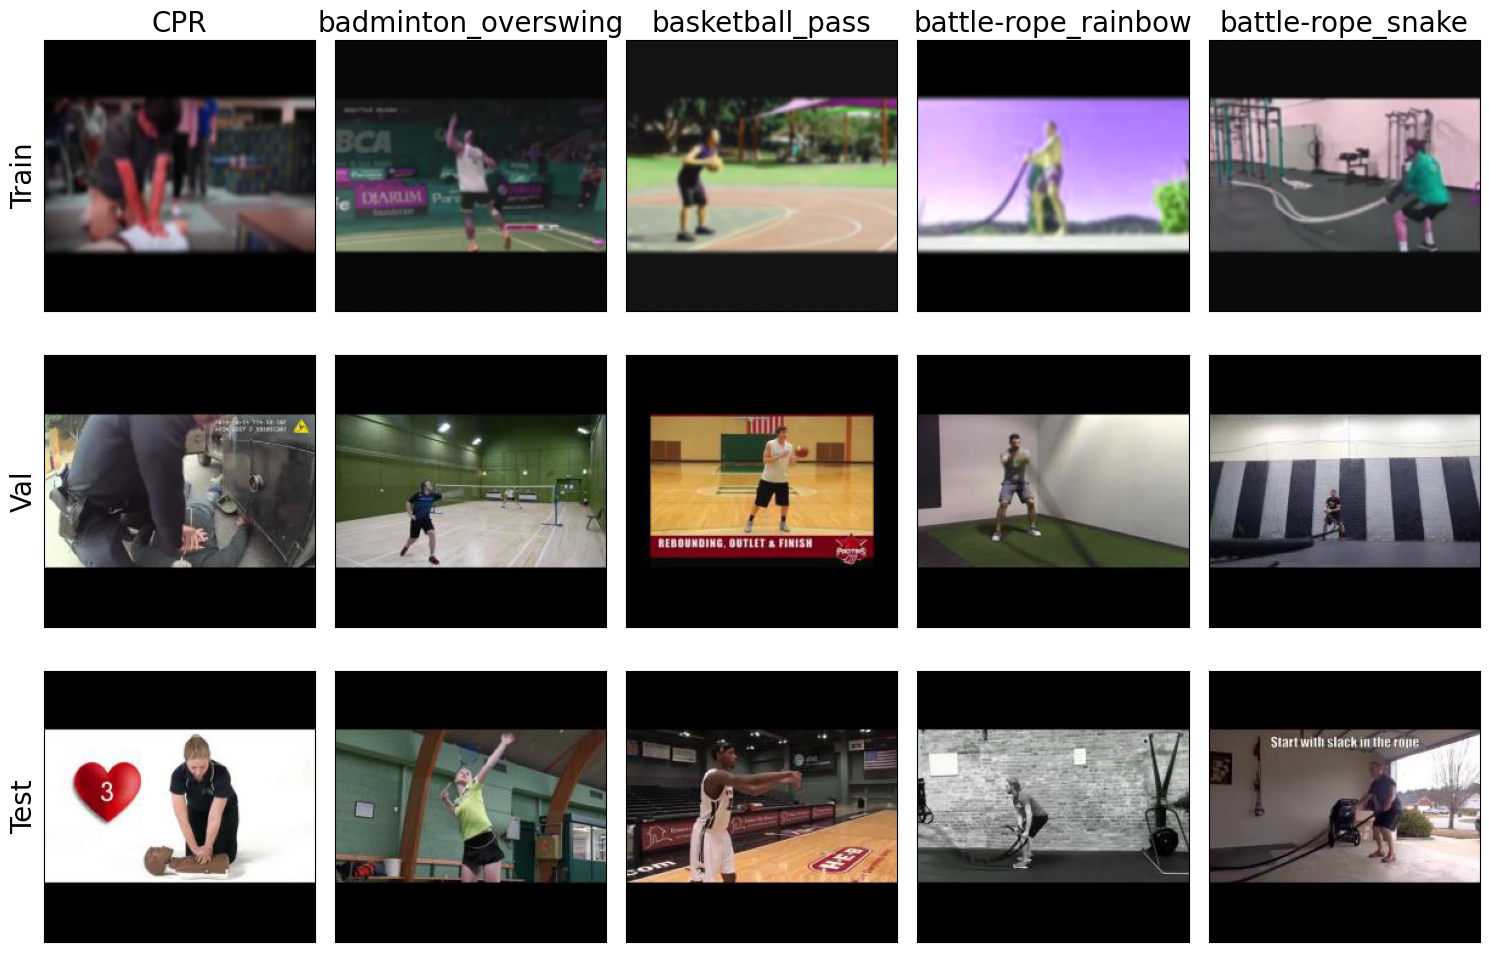

In [15]:
plt.figure(figsize=(15,10))
choose_cats = np.arange(5)

for i in range(5):
    plt.subplot(3,5,i+1)
    plt.imshow(train_dataset.get_im(choose_cats[i]).swapaxes(0,1).swapaxes(1,2))
    plt.title(train_dataset.categories[choose_cats[i]],fontsize=20)
    if i==0:
        plt.ylabel('Train',fontsize=20)
    plt.xticks([]);plt.yticks([])
    
for i in range(5):
    plt.subplot(3,5,i+1+5)
    plt.imshow(val_dataset.get_im(choose_cats[i]).swapaxes(0,1).swapaxes(1,2))
    #plt.axis('off')
    if i==0:
        plt.ylabel('Val',fontsize=20)
    plt.xticks([]);plt.yticks([])
    
for i in range(5):
    plt.subplot(3,5,i+1+10)
    plt.imshow(test_dataset.get_im(choose_cats[i]).swapaxes(0,1).swapaxes(1,2))
    #plt.axis('off')
    if i==0:
        plt.ylabel('Test',fontsize=20)
    plt.xticks([]);plt.yticks([])
    
plt.tight_layout()

In [16]:
criterion = nn.CrossEntropyLoss()                                 # specify the loss function
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)     # specify the optimizer

In [17]:
#val_data = val_dataset.get_batch(64)
val_data = val_dataset.get_batch(128)
val_images = val_data['image'].half()
val_labels = val_data['label'].half()
tmp = []
val_labels = torch.squeeze(val_labels.long())
#val_images, val_labels = val_images.cuda(),  val_labels.cuda()

In [18]:
#print(f'epoch [{epoch}], train loss {epoch_loss:.2f}, ValLoss [{val_loss:.2f}], ValAcc [{val_acc[-1]:.4f}], TrainAcc [{train_acc[-1]:.4f}], T: {now()}')

In [19]:
save_freq = 5                               # specify every how many epochs to save the model
loss_memory = []
val_memory = []
val_acc = []
val_acc5 = []
train_acc = []

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

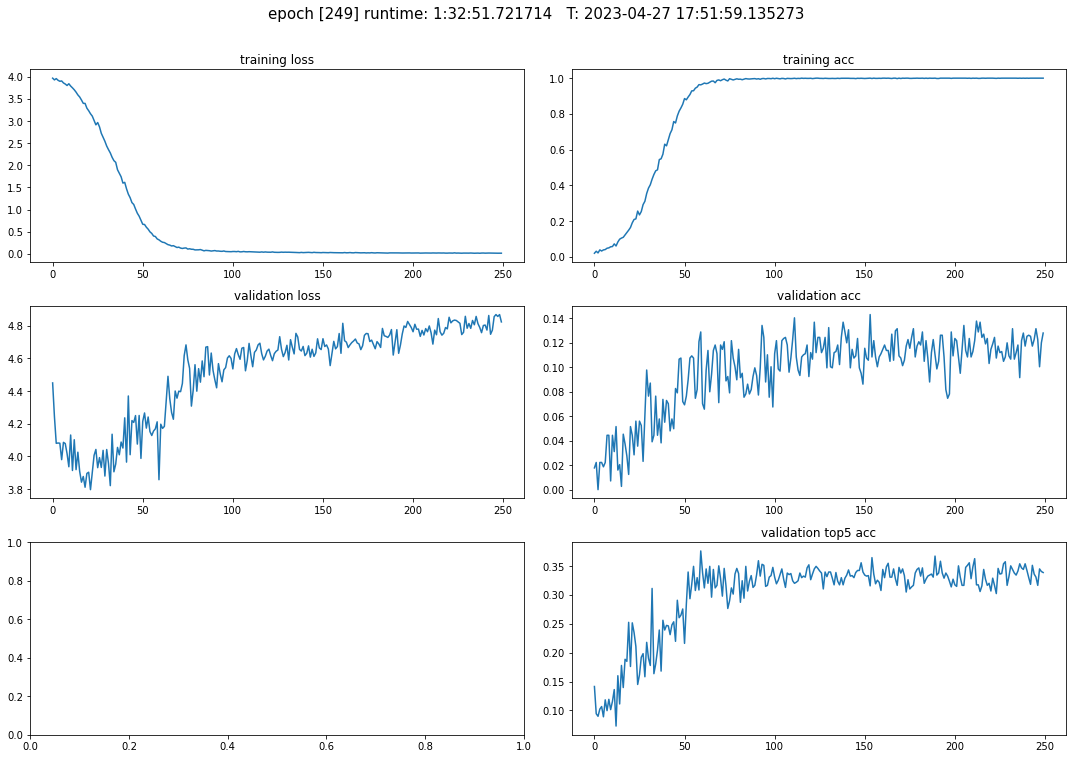

In [16]:
n_batches = 50
for epoch in range(250):  # loop over the dataset multiple times
    running_loss = 0.0
    running_acc = 0.0
    net.train()
    for _ in range(n_batches):
        #torch.cuda.empty_cache() 
        # get the inputs
        data = train_dataset.get_batch(32)
        images = data['image'].half()
        labels = data['label'].half()
        tmp = []
        tmp = torch.squeeze(labels.long())
        images, labels = images.cuda(),  tmp.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        
        running_loss += loss.data.item()
        running_acc += np.array([outputs.detach().cpu().numpy()[jj,:].argmax()==labels.detach().cpu().numpy()[jj] for jj in range(outputs.shape[0])]).mean()
    epoch_loss = running_loss / n_batches
    epoch_acc = running_acc / n_batches
    loss_memory.append(epoch_loss)
    running_loss = 0.0
    
    ## Stuff for Dashboard
    net.eval();
    val_loss = 0
    temp_top1 = 0
    temp_top5 = 0

    for kk in range(25):
        val_images_cuda = torch.tensor(np.array([val_dataset.get_im(i,kk) for i in range(45)])).half().cuda()
        val_labels_cuda = torch.tensor(np.arange(45)).long().cuda()
        val_outputs = net(val_images_cuda)
        val_loss += criterion(val_outputs, val_labels_cuda).data.item()
        val_outputs = val_outputs.detach().cpu().numpy()
        temp_top1 += np.array([jj==val_outputs[jj,:].argsort()[-1] for jj in range(45)]).mean()
        temp_top5 += np.array([jj in val_outputs[jj,:].argsort()[-5::] for jj in range(45)]).mean()

    val_loss = val_loss/(kk+1)
    temp_top1 = temp_top1/(kk+1)
    temp_top5 = temp_top5/(kk+1)
    
    # keep trakc of values for plotting
    val_memory.append( val_loss ) 
    val_acc.append( temp_top1 )
    val_acc5.append( temp_top5 )
    train_acc.append( epoch_acc )
    
    show_dahsboard()
    
torch.save(net.state_dict(), './Data/pytorch-data/weights/weights')
np.save('./Data/pytorch-data/weights/loss_memory.npy',loss_memory)
np.save('./Data/pytorch-data/weights/val_memory.npy',val_memory)
np.save('./Data/pytorch-data/weights/val_acc.npy',val_acc)
np.save('./Data/pytorch-data/weights/val_acc5.npy',val_acc5)
np.save('./Data/pytorch-data/weights/train_acc.npy',train_acc)
#print(f'epoch [{epoch}], train loss {epoch_loss:.2f}, ValLoss [{val_loss:.2f}], ValAcc [{val_acc[-1]:.4f}], TrainAcc [{train_acc[-1]:.4f}]T: {now()')    

In [40]:
net.load_state_dict(torch.load('./Data/pytorch-data/weights/weights'));
net.eval()

loss_memory = np.load('./Data/pytorch-data/weights/loss_memory.npy')
val_memory = np.load('./Data/pytorch-data/weights/val_memory.npy')
val_acc = np.load('./Data/pytorch-data/weights/val_acc.npy')
val_acc5 = np.load('./Data/pytorch-data/weights/val_acc5.npy')
train_acc = np.load('./Data/pytorch-data/weights/train_acc.npy')

In [41]:
def get_confusion_mat(which_dataset):
    top1 = []
    top5 = []
    confusion_matrix = np.zeros((45,45))
    for c in tqdm(range(45)):
        for f in range(len(which_dataset.frames[c])):
            im = torch.tensor(which_dataset.get_im(c,f)[np.newaxis,:,:,:]).half().cuda()
            pred = net(im)
            pred = pred.detach().cpu().numpy()[0]
            confusion_matrix[c,:]+=pred
            top1.append( c==pred.argsort()[-1] )
            top5.append( c in pred.argsort()[-5::] )
        confusion_matrix[c,:] = (confusion_matrix[c,:]-confusion_matrix[c,:].min()) / (confusion_matrix[c,:].max()-confusion_matrix[c,:].min())
    top1 = np.array(top1)
    top5 = np.array(top5)
    
    return {'top1' : top1, 'top5' : top5, 'confusion_matrix' : confusion_matrix}

In [203]:
def plot_dend(confusion_matrix,labels,title=None):
    from scipy.cluster.hierarchy import dendrogram,linkage
    Z = linkage(1-confusion_matrix[np.triu_indices(45,1)],'ward');
    plt.figure(figsize=(15,10));
    plt.subplot(1,2,1);
    plt.imshow(confusion_matrix);
    plt.subplot(1,2,2);
    dendrogram(Z,0,orientation='right',labels=labels);
    plt.tight_layout();
    plt.suptitle(title,fontsize=20,y=1.06)

In [49]:
values_train = get_confusion_mat(train_dataset);

100%|██████████| 45/45 [10:55<00:00, 14.56s/it]


In [43]:
values_val = get_confusion_mat(val_dataset);

100%|██████████| 45/45 [00:42<00:00,  1.07it/s]


In [44]:
values_test = get_confusion_mat(test_dataset);

100%|██████████| 45/45 [00:45<00:00,  1.02s/it]


In [56]:
values_train['top1'].mean().round(3),values_train['top5'].mean().round(3)

(1.0, 1.0)

In [57]:
values_val['top1'].mean().round(3),values_val['top5'].mean().round(3)

(0.108, 0.326)

In [58]:
values_test['top1'].mean().round(3),values_test['top5'].mean().round(3)

(0.116, 0.331)

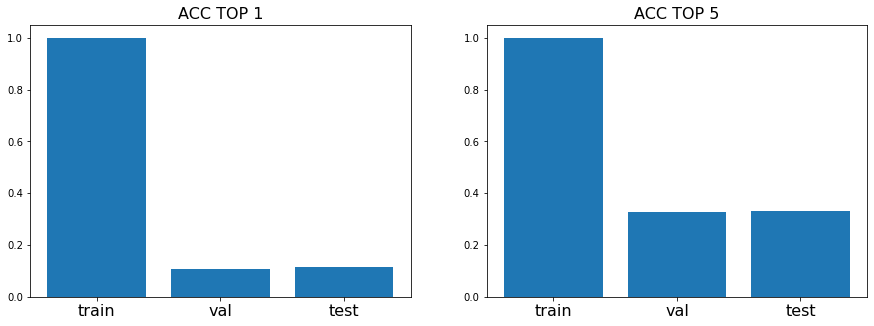

In [95]:
plt.figure(figsize=(15,5));
plt.subplot(1,2,1);
xs = [0,1,2];
ys = [values_train['top1'].mean().round(3),values_val['top1'].mean().round(3),values_test['top1'].mean().round(3)];
plt.bar(xs,ys);
plt.xticks(xs,labels=['train','val','test'],fontsize=16);
plt.title('ACC TOP 1',fontsize=16);
plt.subplot(1,2,2);
xs = [0,1,2];
ys = [values_train['top5'].mean().round(3),values_val['top5'].mean().round(3),values_test['top5'].mean().round(3)];
plt.bar(xs,ys);
plt.xticks(xs,labels=['train','val','test'],fontsize=16);
plt.title('ACC TOP 5',fontsize=16);

In [69]:
cmat_cross = np.corrcoef(np.vstack((values_train['confusion_matrix'][np.triu_indices(45,1)],
                                    values_val['confusion_matrix'][np.triu_indices(45,1)],
                                    values_test['confusion_matrix'][np.triu_indices(45,1)],)))

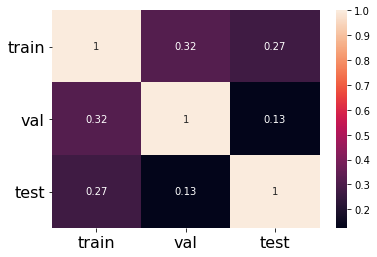

In [84]:
sns.heatmap(cmat_cross,annot=True);
plt.xticks([.5,1.5,2.5],labels=['train','val','test'],fontsize=16);
plt.yticks([.5,1.5,2.5],labels=['train','val','test'],fontsize=16,rotation=0);

In [217]:
#plt.imshow(training_dataset.get_im(27,500).swapaxes(0,1).swapaxes(1,2))

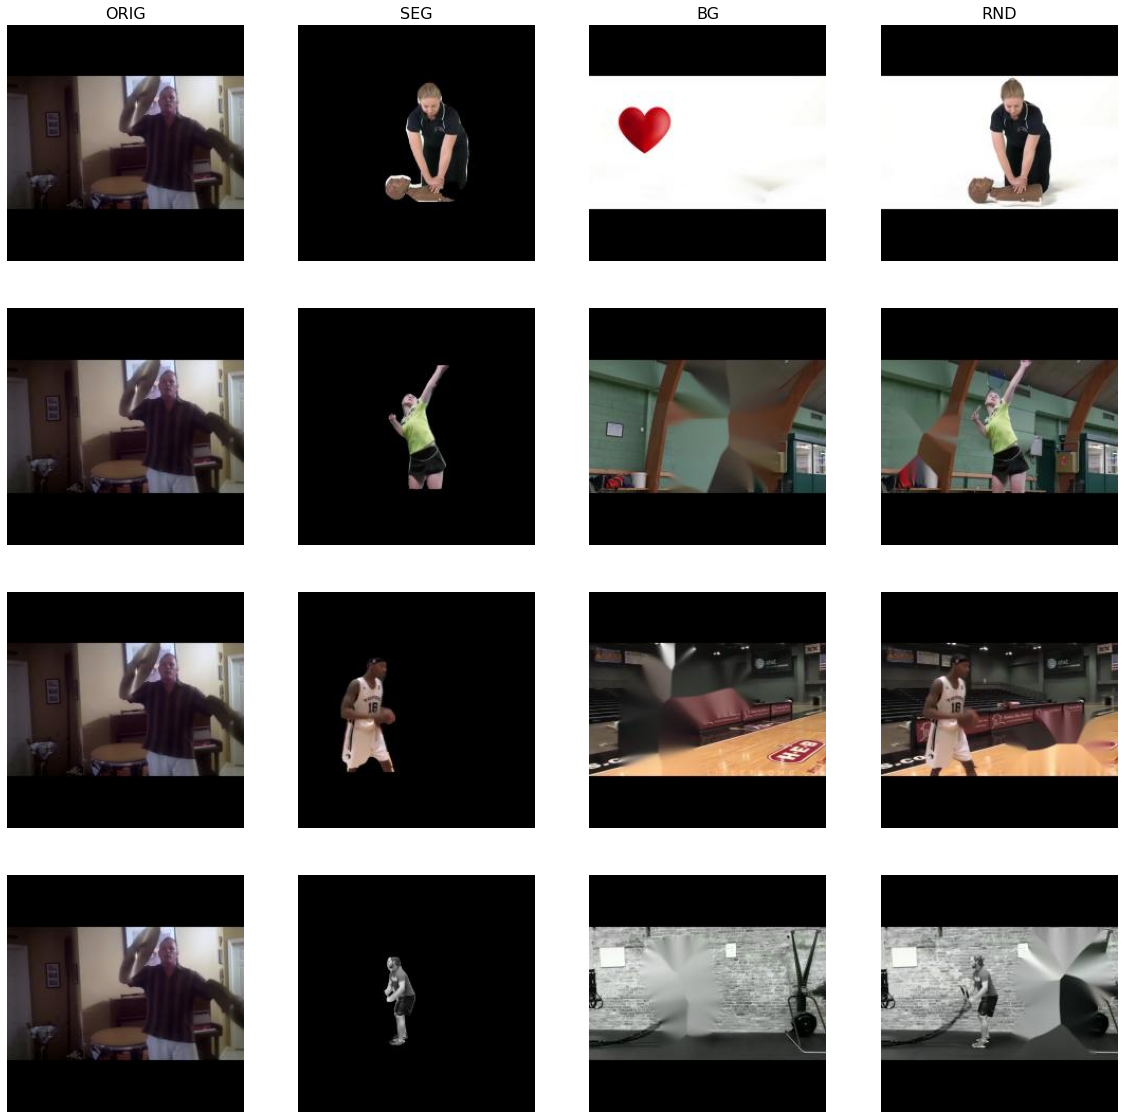

In [211]:
plt.figure(figsize=(20,20))
nc = 4
c = 0
for j in range(nc):
    c+=1;plt.subplot(nc,4,c)
    plt.imshow(test_dataset.get_im(27,0).swapaxes(0,1).swapaxes(1,2))
    plt.axis('off');
    #plt.title('ORIG') if c==1 else pass
    if c==1 : plt.title('ORIG',fontsize=16)

    c+=1;plt.subplot(nc,4,c)
    plt.imshow(seg_test_dataset.get_im(27,0).swapaxes(0,1).swapaxes(1,2))
    plt.axis('off');
    if c==2 : plt.title('SEG',fontsize=16)

    c+=1;plt.subplot(nc,4,c)
    plt.imshow(bg_test_dataset.get_im(j,0).swapaxes(0,1).swapaxes(1,2))
    plt.axis('off');
    if c==3 : plt.title('BG',fontsize=16)

    c+=1;plt.subplot(nc,4,c)
    plt.imshow(rnd_test_dataset.get_im(j,0).swapaxes(0,1).swapaxes(1,2))
    plt.axis('off');
    if c==4 : plt.title('RND',fontsize=16)
    
#plt.tight_layout()

In [96]:
seg_train_dataset = HAA_dataset('./Data/pytorch-data/action_data_seg/train',usage='train')
seg_val_dataset = HAA_dataset('./Data/pytorch-data/action_data_seg/val',usage='val')
seg_test_dataset = HAA_dataset('./Data/pytorch-data/action_data_seg/test',usage='test')

In [100]:
bg_train_dataset = HAA_dataset('./Data/pytorch-data/action_data_bg/train',usage='train')
bg_val_dataset = HAA_dataset('./Data/pytorch-data/action_data_bg/val',usage='val')
bg_test_dataset = HAA_dataset('./Data/pytorch-data/action_data_bg/test',usage='test')

In [97]:
rnd_train_dataset = HAA_dataset('./Data/pytorch-data/action_data_rnd/train',usage='train')
rnd_val_dataset = HAA_dataset('./Data/pytorch-data/action_data_rnd/val',usage='val')
rnd_test_dataset = HAA_dataset('./Data/pytorch-data/action_data_rnd/test',usage='test')

In [98]:
values_train_seg = get_confusion_mat(seg_train_dataset);
values_val_seg = get_confusion_mat(seg_val_dataset);
values_test_seg = get_confusion_mat(seg_test_dataset);

100%|██████████| 45/45 [00:19<00:00,  2.28it/s]


In [101]:
values_train_bg = get_confusion_mat(bg_train_dataset);
values_val_bg = get_confusion_mat(bg_val_dataset);
values_test_bg = get_confusion_mat(bg_test_dataset);

100%|██████████| 45/45 [00:20<00:00,  2.24it/s]


In [102]:
values_train_rnd = get_confusion_mat(rnd_train_dataset);
values_val_rnd = get_confusion_mat(rnd_val_dataset);
values_test_rnd = get_confusion_mat(rnd_test_dataset);

 98%|█████████▊| 44/45 [00:17<00:00,  2.14it/s]<ipython-input-41-bd135e526f65>:13: RuntimeWarning: invalid value encountered in true_divide
  confusion_matrix[c,:] = (confusion_matrix[c,:]-confusion_matrix[c,:].min()) / (confusion_matrix[c,:].max()-confusion_matrix[c,:].min())
100%|██████████| 45/45 [00:19<00:00,  2.32it/s]


Text(0.5, 0.98, 'TRAINING')

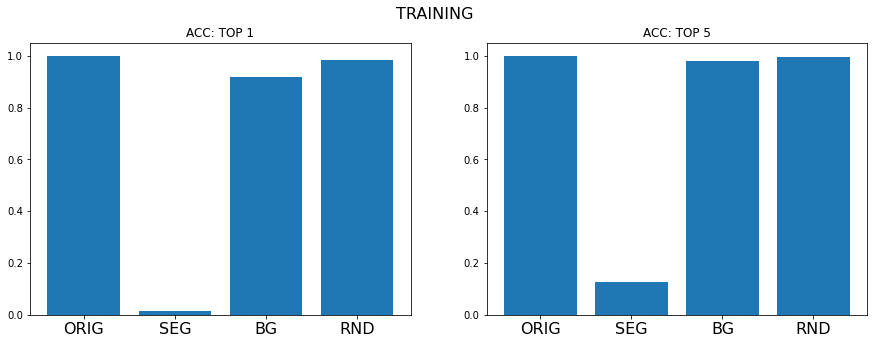

In [176]:
plt.figure(figsize=(15,5));
plt.subplot(1,2,1)
xs = [0,1,2,3]
lbls = ['ORIG','SEG','BG','RND']
ys = [values_train['top1'].mean(),
values_train_seg['top1'].mean(),
values_train_bg['top1'].mean(),
values_train_rnd['top1'].mean()]
plt.bar(xs,ys)
plt.xticks(xs,labels=lbls,fontsize=16)
plt.title('ACC: TOP 1')

plt.subplot(1,2,2)
xs = [0,1,2,3]
ys = [values_train['top5'].mean(),
values_train_seg['top5'].mean(),
values_train_bg['top5'].mean(),
values_train_rnd['top5'].mean()]
plt.bar(xs,ys)
plt.xticks(xs,labels=lbls,fontsize=16)
plt.title('ACC: TOP 5')
plt.suptitle('TRAINING',fontsize=16)

In [187]:
values_train_seg['top5'].mean()

0.12485811577752554

In [188]:
values_val_seg['top5'].mean()

0.13737864077669903

In [189]:
values_test_seg['top5'].mean()

0.1431095406360424

Text(0.5, 0.98, 'VALIDATION')

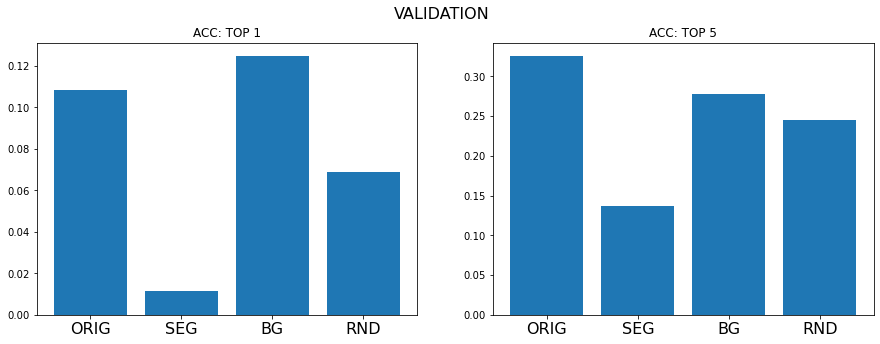

In [177]:
plt.figure(figsize=(15,5));
plt.subplot(1,2,1)
xs = [0,1,2,3]
lbls = ['ORIG','SEG','BG','RND']
ys = [values_val['top1'].mean(),
values_val_seg['top1'].mean(),
values_val_bg['top1'].mean(),
values_val_rnd['top1'].mean()]
plt.bar(xs,ys)
plt.xticks(xs,labels=lbls,fontsize=16)
plt.title('ACC: TOP 1')

plt.subplot(1,2,2)
xs = [0,1,2,3]
ys = [values_val['top5'].mean(),
values_val_seg['top5'].mean(),
values_val_bg['top5'].mean(),
values_val_rnd['top5'].mean()]
plt.bar(xs,ys)
plt.xticks(xs,labels=lbls,fontsize=16)
plt.title('ACC: TOP 5')
plt.suptitle('VALIDATION',fontsize=16)

Text(0.5, 0.98, 'TEST')

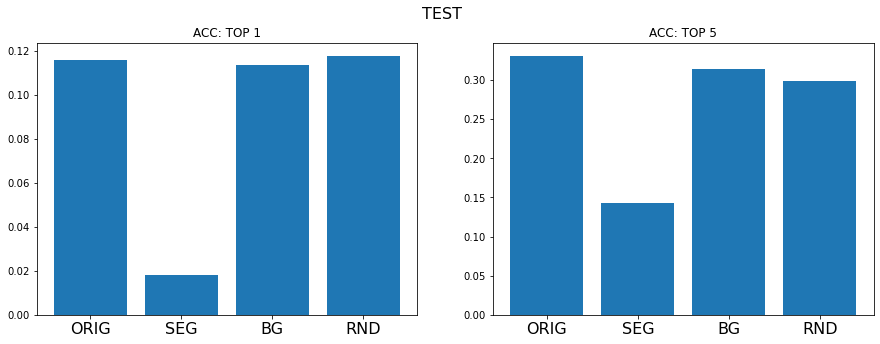

In [178]:
plt.figure(figsize=(15,5));
plt.subplot(1,2,1)
xs = [0,1,2,3]
lbls = ['ORIG','SEG','BG','RND']
ys = [values_test['top1'].mean(),
values_test_seg['top1'].mean(),
values_test_bg['top1'].mean(),
values_test_rnd['top1'].mean()]
plt.bar(xs,ys)
plt.xticks(xs,labels=lbls,fontsize=16)
plt.title('ACC: TOP 1')

plt.subplot(1,2,2)
xs = [0,1,2,3]
ys = [values_test['top5'].mean(),
values_test_seg['top5'].mean(),
values_test_bg['top5'].mean(),
values_test_rnd['top5'].mean()]
plt.bar(xs,ys)
plt.xticks(xs,labels=lbls,fontsize=16)
plt.title('ACC: TOP 5')
plt.suptitle('TEST',fontsize=16)

In [ ]:
## FLIP order of BG amd SEG

Text(0.5, 0.98, 'Confusion Matrix Similarity')

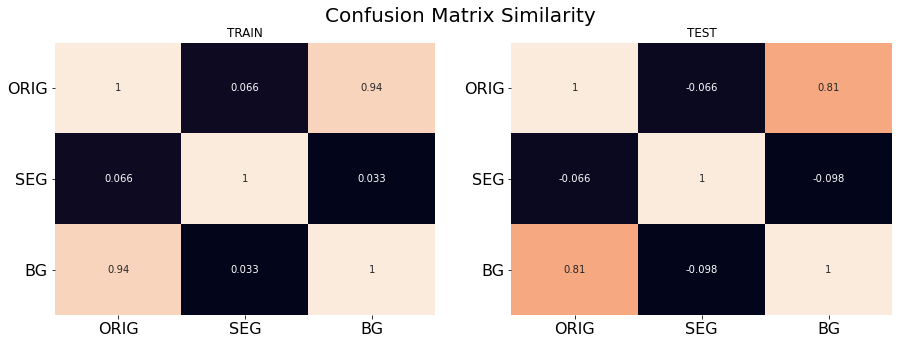

In [140]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
cmat_cross = np.corrcoef(np.vstack((values_train['confusion_matrix'][np.triu_indices(45,1)],
values_train_seg['confusion_matrix'][np.triu_indices(45,1)],
values_train_bg['confusion_matrix'][np.triu_indices(45,1)])))

sns.heatmap(cmat_cross,annot=True,cbar=False);
plt.xticks([.5,1.5,2.5],labels=['ORIG','SEG','BG'],fontsize=16);
plt.yticks([.5,1.5,2.5],labels=['ORIG','SEG','BG'],fontsize=16,rotation=0);
plt.title('TRAIN');

plt.subplot(1,2,2)
cmat_cross = np.corrcoef(np.vstack((values_test['confusion_matrix'][np.triu_indices(45,1)],
values_test_seg['confusion_matrix'][np.triu_indices(45,1)],
values_test_bg['confusion_matrix'][np.triu_indices(45,1)])))

sns.heatmap(cmat_cross,annot=True,cbar=False);
plt.xticks([.5,1.5,2.5],labels=['ORIG','SEG','BG'],fontsize=16);
plt.yticks([.5,1.5,2.5],labels=['ORIG','SEG','BG'],fontsize=16,rotation=0);
plt.title('TEST');

plt.suptitle('Confusion Matrix Similarity',fontsize=20)

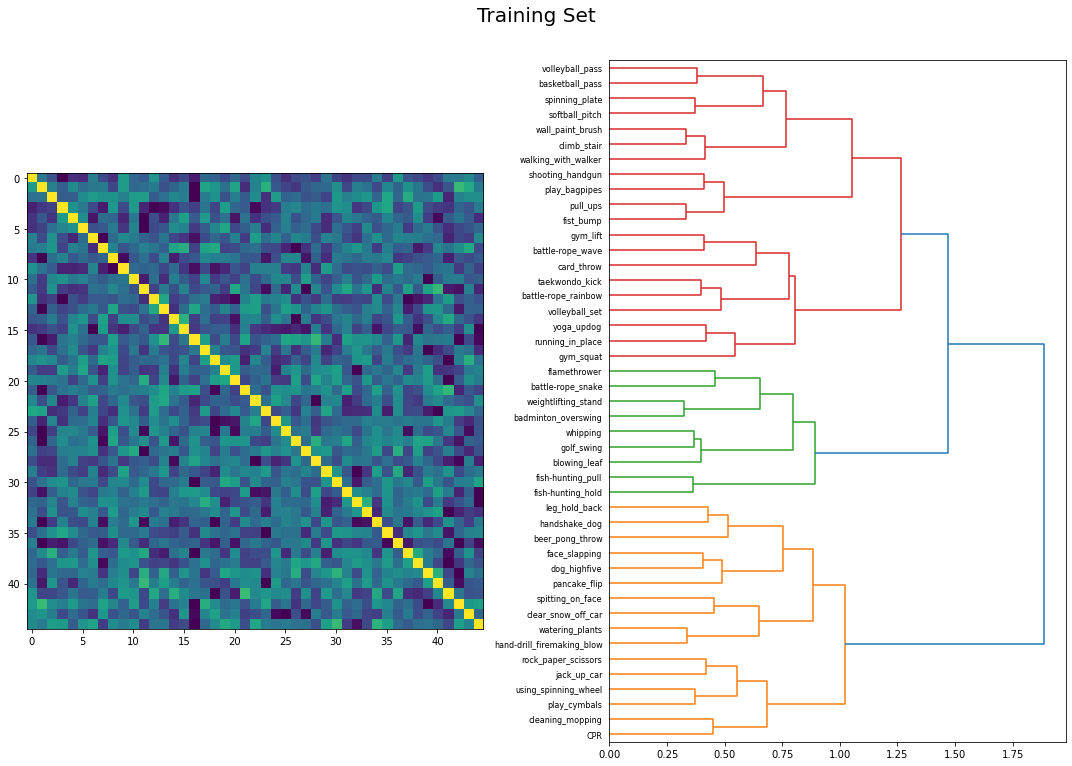

In [204]:
plot_dend(values_train['confusion_matrix'],val_dataset.categories,title='Training Set')

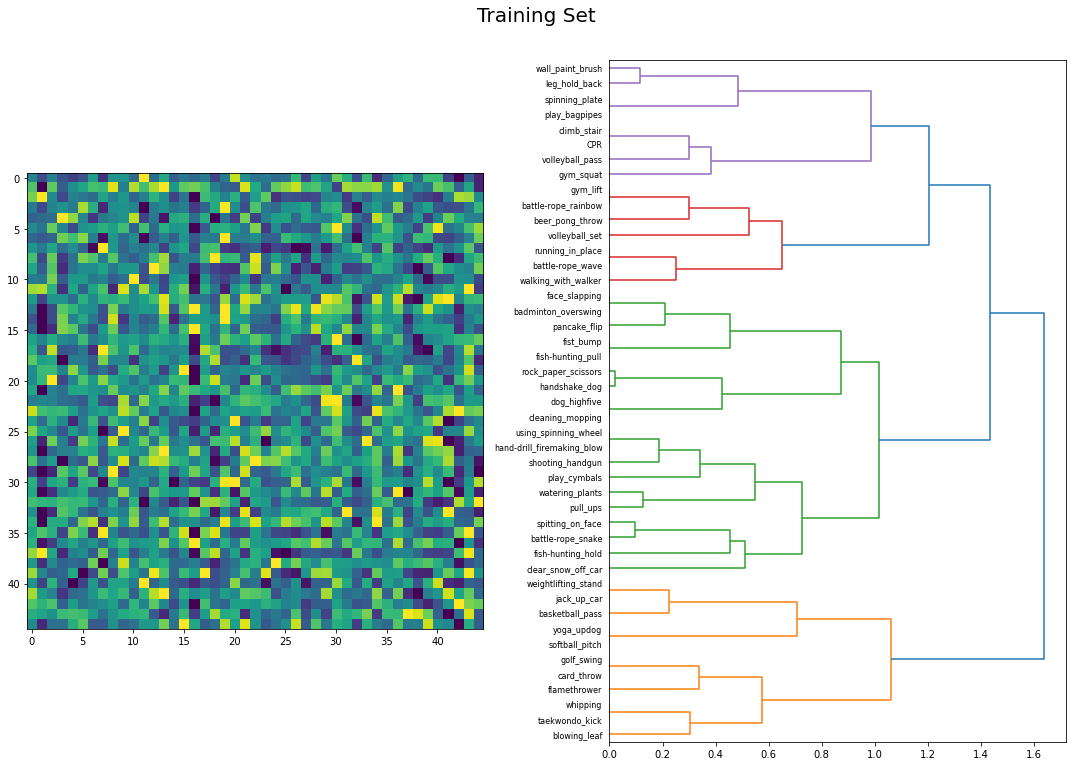

In [207]:
plot_dend(values_test['confusion_matrix'],test_dataset.categories,title='Testing Set')

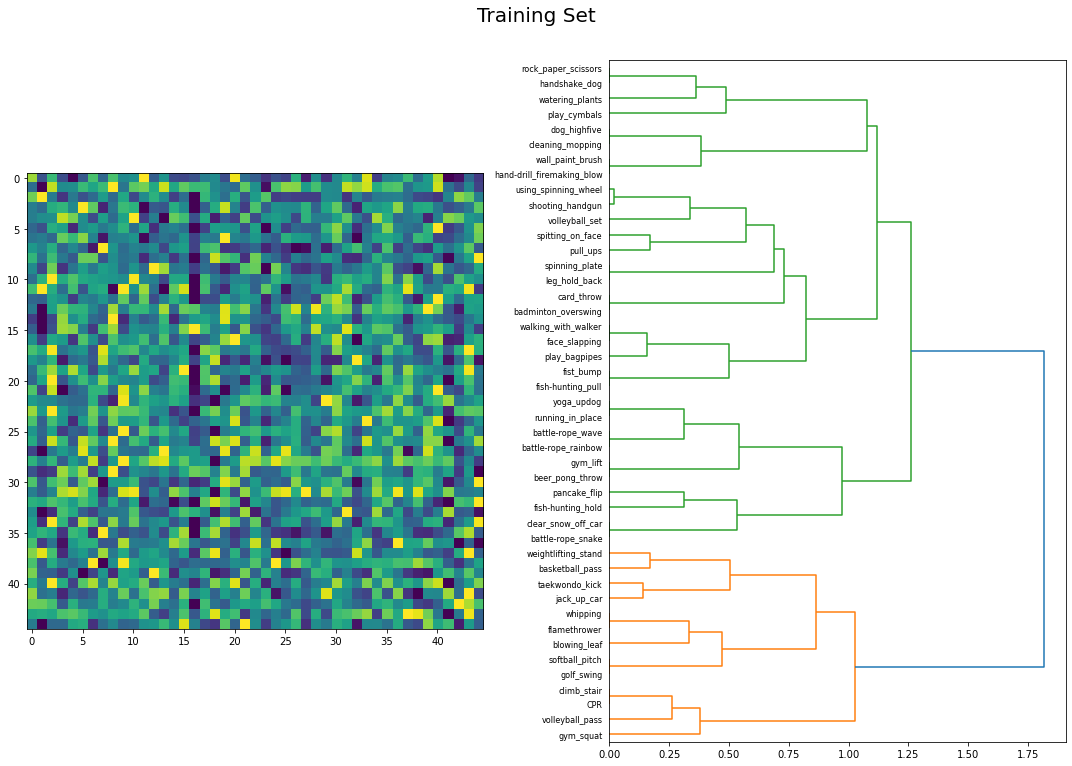

In [209]:
plot_dend(values_test_bg['confusion_matrix'],seg_test_dataset.categories,title='Training Set')

In [ ]:
## 27 

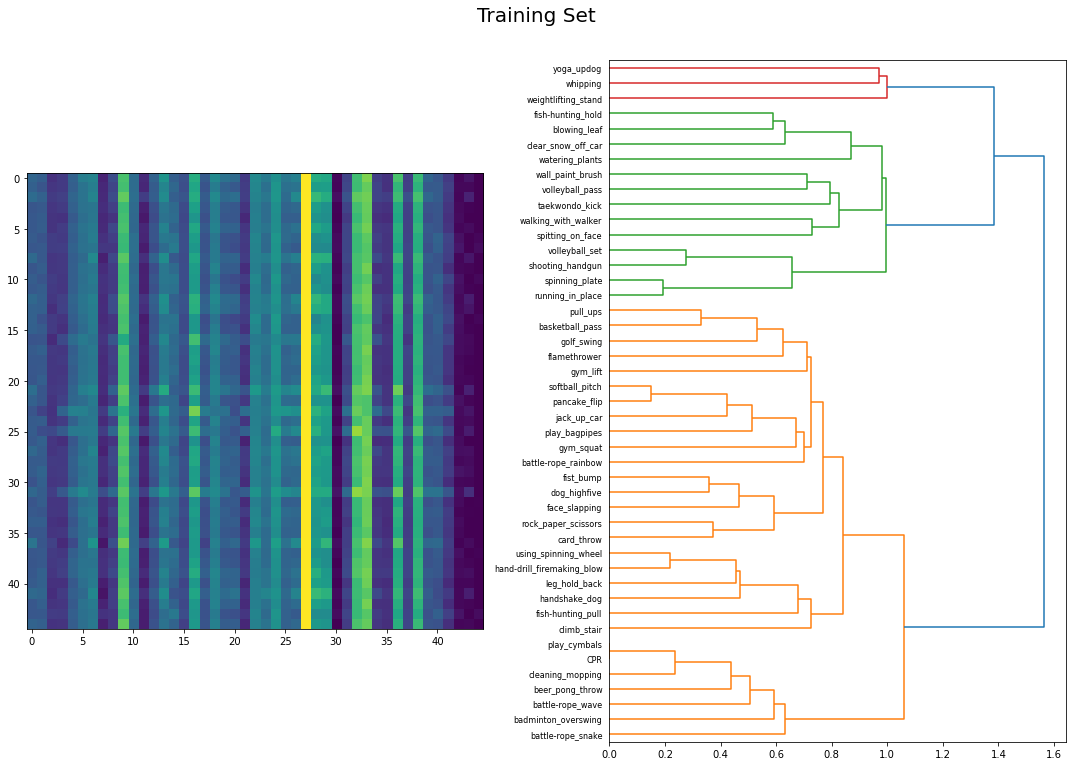

In [208]:
plot_dend(values_test_seg['confusion_matrix'],seg_test_dataset.categories,title='Training Set')

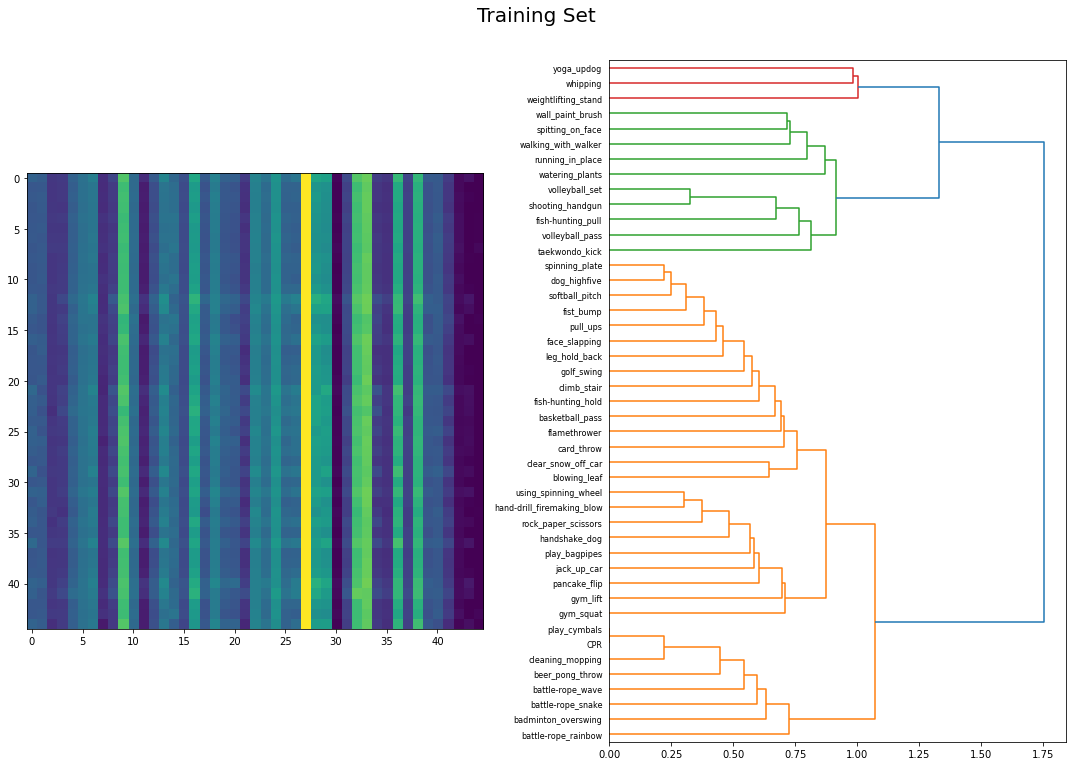

In [210]:
# check cat 27
plot_dend(values_train_seg['confusion_matrix'],seg_test_dataset.categories,title='Training Set')

In [93]:
np.corrcoef(confusion_matrix[np.triu_indices(45,1)],confusion_matrix_train[np.triu_indices(45,1)])[0,1]

0.6071941940316126

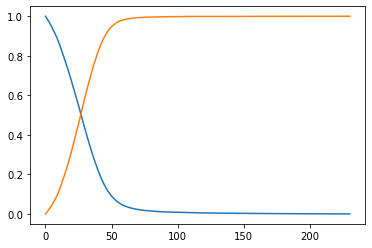

In [96]:
k = 20
plt.plot(norm(moving_average(loss_memory,k)))
plt.plot(norm(moving_average(train_acc,k)))

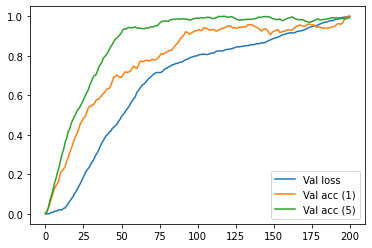

In [101]:
#plt.plot(norm(val_memory))
k = 50
plt.plot(norm(moving_average(val_memory,k)))
plt.plot(norm(moving_average(val_acc,k)))
plt.plot(norm(moving_average(val_acc5,k)))
plt.legend(['Val loss','Val acc (1)','Val acc (5)'])

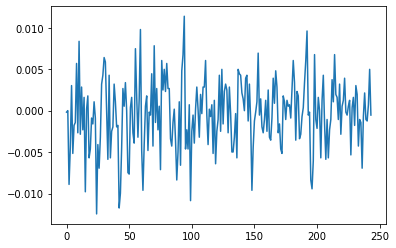

In [119]:
k = 5
plt.plot((np.hstack((0,moving_average(val_acc,k)))-np.hstack((moving_average(val_acc,k),0)))[1:-2] )

In [139]:
k = 50

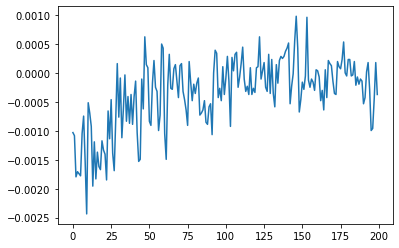

In [140]:
plt.plot(moving_average(val_acc,k)[0:-1]-moving_average(val_acc,k)[1::])